In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import math
import maxflow

# Grab Cut - Ajay Shrihari

## Method
- We use the Grab cut algorithm for foreground segmentation. In the implementation, there are four classes - 0 -> background, 1 -> foreground, 2 -> probably background, 3 -> probably background. The bounding box given in the dataset/selected by the programmed interactive tool gives a rectangle, which is the probable foreground class. We then learn the GMM models for the foreground and background, and weight the neighbouring nodes based on the class labels edges from source and sink. Based on these weights, a graph is constructed. Edge weights are assigned with likelihoods based on the class. A mincut breaks the graph, and we iteratively repeat this process until we get convergence.
- The library PyMaxflow was used for finding the mincut/maxflow. 

In [3]:
def get_mask(img, rect):
    '''
    Create mask based on bounding box
    Mask inside: Foreground
    '''
    mask = np.zeros(img.shape[:2])
    mask[rect[1]:rect[3],rect[0]:rect[2]] = 3
    return mask

In [4]:
def GMM(img, mask, bkgGMM, fgGMM):
    '''
    Assign pixels to foreground and background. Fit GMM's 
    '''
    fg = []
    bkg = []
    x = img.shape[0]
    y = img.shape[1]
    for i in range(x):
        for j in range(y):
            if (int(mask[i][j]) == 0 or int(mask[i][j]) == 2):
                bkg.append(img[i][j])
            else:
                fg.append(img[i][j])
    return bkgGMM.fit(np.array(bkg)), fgGMM.fit(np.array(fg))
    

In [5]:
def find_beta(img, num_neighbour = 8): 
    '''
    Function to find beta. 8 neighbours and 4 neighbours. 
    4 neighbours - left and up 
    8 neighbours - left, upper left, up, upper right
    Beta value used to find edge weights of neighbours in the making of graph
    '''
    if num_neighbour == 8:
        beta = 0
        x = img.shape[0]
        y = img.shape[1]
        for i in range(x):
            for j in range(y):
                pix = img[i][j]
                if (j>0):
                    d = pix - img[i][j-1]
                    beta = beta + np.dot(d,d)
                if (i>0 and j>0):
                    d = pix - img[i-1][j-1]
                    beta = beta + np.dot(d, d)
                if (i>0):
                    d = pix - img[i-1][j]
                    beta = beta + np.dot(d, d)
                if (i>0 and j<y-1):
                    d = pix - img[i-1][j+1]
                    beta = beta + np.dot(d, d)
        num_edge = (4*y*x - 3*y - 3*x +2)
        return 1.00/(2*beta/num_edge)
    if num_neighbour == 4:
        beta = 0
        x = img.shape[0]
        y = img.shape[1]
        for i in range(x):
            for j in range(y):
                pix = img[i][j]
                if (j>0):
                    d = pix - img[i][j-1]
                    beta = beta + np.dot(d,d)
                
                if (i>0):
                    d = pix - img[i-1][j]
                    beta = beta + np.dot(d, d)
                
        num_edge = (2*y*x - y - x +2)
        return 1.00/(2*beta/num_edge)
        

In [6]:
def weights(img, beta, gamma, num_neighbour = 8):
    """
    Calculate weights for vertices that are not the source and sink
    Beta and gamma - inputs, calculated in different functions
    """
    if num_neighbour == 8:
        x = img.shape[0]
        y = img.shape[1]
        gamma2 = gamma/math.sqrt(2.00)
        lw, ulw, uw, upw  = np.zeros((x,y)), np.zeros((x,y)), np.zeros((x,y)), np.zeros((x,y))
        for i in range(x):
            for j in range(y):
                pix = img[i][j]
                if (j>=1):# left
                    d = pix - img[i][j-1]
                    lw[i][j] = gamma * math.exp(-beta*np.dot(d,d))
                if (j>=1 and i>=1):# upleft
                    d = pix - img[i-1][j-1]
                    ulw[i][j] = gamma2 * math.exp(-beta*np.dot(d,d))
                if (i>=1):#up
                    d = pix - img[i-1][j]
                    uw[i][j] = gamma * math.exp(-beta*np.dot(d,d))
                if (j<y-1 and i>=1):# upright
                    d = pix - img[i-1][j+1]
                    upw[i][j] = gamma2 * math.exp(-beta*np.dot(d,d))
        return lw, ulw, uw, upw
    if num_neighbour == 4:
        x = img.shape[0]
        y = img.shape[1]
#         gamma2 = gamma/math.sqrt(2.00)
        lw, uw  = np.zeros((x,y)), np.zeros((x,y))
        for i in range(x):
            for j in range(y):
                pix = img[i][j]
                if (j>=1):
                    d = pix - img[i][j-1]
                    lw[i][j] = gamma * math.exp(-beta*np.dot(d,d))
                if (i>=1):
                    d = pix - img[i-1][j]
                    uw[i][j] = gamma * math.exp(-beta*np.dot(d,d))
                
        return lw, uw
        

In [7]:
def make_graph(img, mask, bkgGMM, fgGMM, lmbda, lw,ulw,  uw, upw, num_neighbour = 8):
    """
    Build graph and add edges
    """
    if num_neighbour == 8:
        x = img.shape[0]
        y = img.shape[1]
        num_edge = 2* (4*y*x - 3*y - 3*x +2)
        num_vertex = x * y
        graph = maxflow.Graph[float](num_vertex, num_edge)
        graph.add_nodes(num_vertex)
        src = -bkgGMM.score_samples(img.reshape(x*y,3))
        snk = -fgGMM.score_samples(img.reshape(x*y,3))
        for i in range(x):
            for j in range(y):
                #terminal 
                v_id = i*img.shape[1] + j
                pix = img[i][j]
                source = None
                sink = None
                if (mask[i][j] == 2 or mask[i][j] == 3):
                    source = src[v_id]
                    sink = snk[v_id]
                elif (mask[i][j] == 0):
                    source = 0
                    sink = lmbda
                else:
                    source = lmbda
                    sink = 0
                graph.add_tedge(v_id, source, sink)
                if (j>0):
                    # non terminal
                    graph.add_edge(v_id, v_id-1, lw[i][j], lw[i][j])
                if (j>0 and i>0):
                    graph.add_edge(v_id, v_id-y-1, ulw[i][j], ulw[i][j])
                if (i>0):
                    graph.add_edge(v_id, v_id-y, uw[i][j], uw[i][j])
                if (j<y-1 and i>0):
                    graph.add_edge(v_id, v_id -y+1, upw[i][j], upw[i][j])
        return graph 
        if num_neighbour == 4:
            x = img.shape[0]
            y = img.shape[1]
            num_edge = 2* (4*y*x - 3*y - 3*x +2)
            num_vertex = x * y
            graph = maxflow.Graph[float](num_vertex, num_edge)
            graph.add_nodes(num_vertex)
            src = -bkgGMM.score_samples(img.reshape(x*y,3))
            snk = -fgGMM.score_samples(img.reshape(x*y,3))
            for i in range(x):
                for j in range(y):
                    v_id = i*img.shape[1] + j
                    pix = img[i][j]
                    source = None
                    sink = None
                    if (mask[i][j] == 2 or mask[i][j] == 3):
                        source = src[v_id]
                        sink = snk[v_id]
                    elif (mask[i][j] == 0):
                        source = 0
                        sink = lmbda
                    else:
                        source = lmbda
                        sink = 0
                    graph.add_tedge(v_id, source, sink)
                    if (j>0):
                        graph.add_edge(v_id, v_id-1, lw[i][j], lw[i][j])
                   
                    if (i>0):
                        graph.add_edge(v_id, v_id-y, uw[i][j], uw[i][j])
            
            return graph

            

In [8]:
def mincut_maxflow(graph, mask):
    """
    Use PyMaxflow to calculate the mincut of the graph
    """
    x = mask.shape[0]
    y = mask.shape[1]
    minimum = graph.maxflow()
    partition = graph.get_grid_segments(np.arange(mask.shape[0]*mask.shape[1])).reshape(mask.shape).astype('int')
    partition[partition==1] = 2
    partition[partition==0] = 3
    mask = (mask>0)*partition
    return mask

In [9]:
def grabcut(img, rect, num_iter = 2, num_components = 3, num_neighbour= 8, gamma = 50):
    """
    Function to tie everything together
    """
    bkgGMM = GaussianMixture(n_components = num_components, covariance_type = 'full')
    fgGMM = GaussianMixture(n_components = num_components, covariance_type = 'full')
    mask = get_mask(img, rect)
    gamma = gamma
    lmbda = 9 * gamma
    beta = find_beta(img, num_neighbour = num_neighbour)
    if num_neighbour == 8:
        lw, ulw, uw, upw = weights(img, beta, gamma, num_neighbour = num_neighbour)
    if num_neighbour == 4:
        lw, uw = weights(img, beta, gamma, num_neighbour = num_neighbour)
        ulw = []
        upw = []
        
    for i in range(num_iter):
        bkgGMM, fgGMM = GMM(img, mask, bkgGMM, fgGMM)
        graph = make_graph(img, mask, bkgGMM, fgGMM, lmbda, lw, ulw, uw, upw, num_neighbour = num_neighbour)
        mask = mincut_maxflow(graph, mask)
        mask_corr = np.where((mask == 1)+(mask == 3), 255, 0).astype('uint8')
        out = cv2.bitwise_and(img, img, mask = mask_corr)
#         cv2.imwrite()
    return out

In [10]:
def image_list(name):
    dir_im = './images'
    path = dir_im + '/' + name + '.jpg'
    return plt.imread(path)

In [11]:
def bbox_list(name):
    dir_box = './bboxes/'    
    with open(dir_box + '/' + name + '.txt', "r") as f:
        for line in f:
            x = line.split(' ')
    return tuple(map(int, x))

In [12]:
def interactive(img):
    """
    Function to make interactive GUI application for selecting foreground bounding box
    """
    r = cv2.selectROI(img,False,False)
    cv2.destroyAllWindows()
    return [r[0],r[1],r[0]+r[2],r[1]+r[3]]

## 1. Testing output for different images

- Flower for 2 iterations.
- Banana1 for 3 iterations.
- Accurate segmentation received.

In [145]:
name = 'flower'
img = image_list(name)
out = grabcut(image_list(name), bbox_list(name),2)

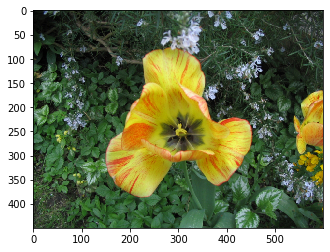

In [146]:
plt.imshow(img)

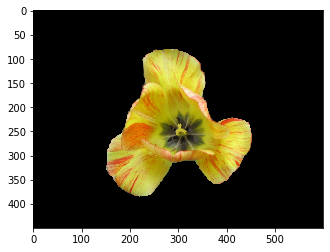

In [147]:
plt.imshow(out)

In [13]:
name = 'banana1'
img = image_list(name)
out = grabcut(image_list(name), bbox_list(name),3)
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: './images/banana1.jpg'

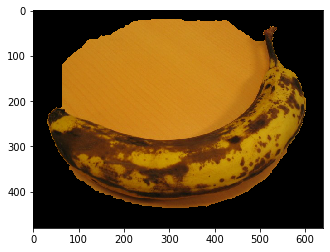

In [149]:
plt.imshow(out)

## 2. Interactive output

cv2.SelectROI was used for this process. The output of the flower with the bounding box selected by the user is given below.

In [16]:
name = 'flower'
img = image_list(name)
bbox = interactive(img)
out = grabcut(image_list(name), bbox,3)

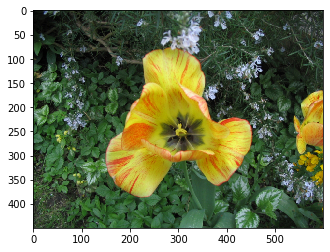

In [41]:
plt.imshow(img)

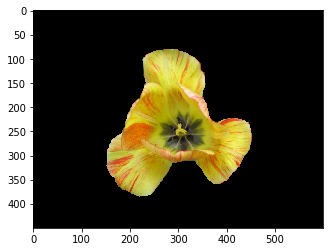

In [17]:
plt.imshow(out)

## 3.Varying number of iterations
- Grave picture used, with iterations 1-10 tested
- We can see from this that with increased number of iterations, the segmentation gets better 

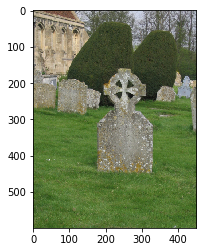

In [49]:
## Varying number of iterations
name = 'grave'
img = image_list(name)
out1 = grabcut(image_list(name), bbox_list(name),1)
out2 = grabcut(image_list(name), bbox_list(name),2)
out3 = grabcut(image_list(name), bbox_list(name),3)
out3 = grabcut(image_list(name), bbox_list(name),4)
out4 = grabcut(image_list(name), bbox_list(name),4)
out5 = grabcut(image_list(name), bbox_list(name),5)
out6 = grabcut(image_list(name), bbox_list(name),6)
out7 = grabcut(image_list(name), bbox_list(name),7)
out8 = grabcut(image_list(name), bbox_list(name),8)
out9 = grabcut(image_list(name), bbox_list(name),9)
out10 = grabcut(image_list(name), bbox_list(name),10)
plt.imshow(img)

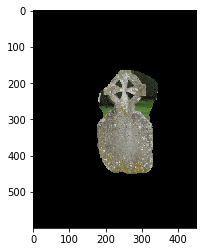

In [51]:
plt.imshow(out1)

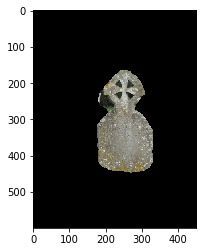

In [52]:
plt.imshow(out2)

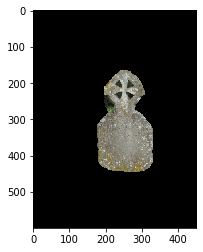

In [53]:
plt.imshow(out3)

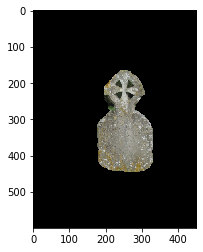

In [54]:
plt.imshow(out4)

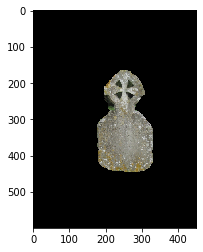

In [55]:
plt.imshow(out5)

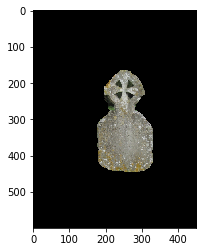

In [56]:
plt.imshow(out6)

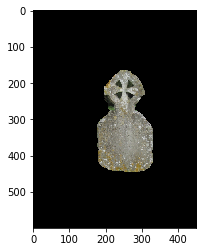

In [57]:
plt.imshow(out7)

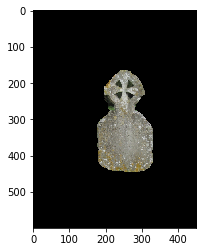

In [58]:
plt.imshow(out8)

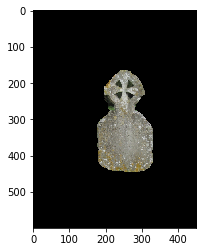

In [59]:
plt.imshow(out9)

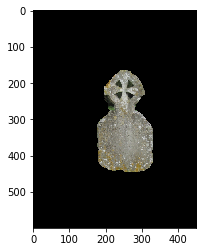

In [60]:
plt.imshow(out10)

## 4. Varying number of components
- We use the llama picture in the dataset increase the number of components = [1,2,3,5,7 ]in the GMM, and observe the results ,while keeping the number of iterations constant.
- We can see that the image is best modelled by a gaussian with number of components = 5
- This will vary from image to image

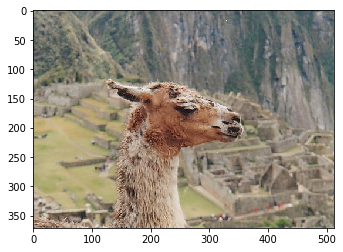

In [61]:
name = 'llama'
img = image_list(name)
out1 = grabcut(image_list(name), bbox_list(name),2, num_components = 1)
out2 = grabcut(image_list(name), bbox_list(name),2, num_components = 3)
out3 = grabcut(image_list(name), bbox_list(name),2, num_components = 5)
out4 = grabcut(image_list(name), bbox_list(name),2, num_components = 7)
plt.imshow(img)

In [66]:
out5 = grabcut(image_list(name), bbox_list(name),2, num_components = 2)

Num_components = 1


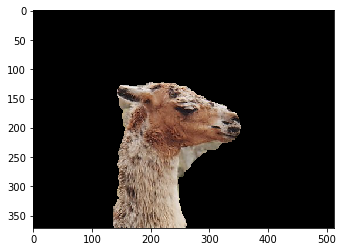

In [62]:
print ("Num_components = 1")
plt.imshow(out1)

Num_components = 2


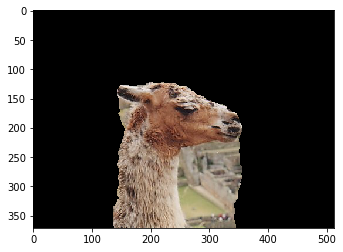

In [67]:
print ("Num_components = 2")
plt.imshow(out5)

Num_components = 3


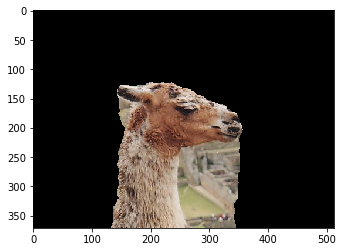

In [63]:
print ("Num_components = 3")
plt.imshow(out2)

Num_components = 5


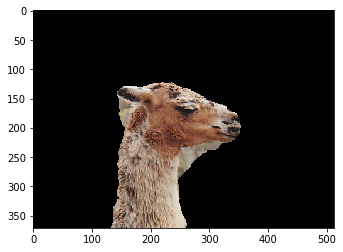

In [64]:
print ("Num_components = 5")
plt.imshow(out3)

Num_components = 7


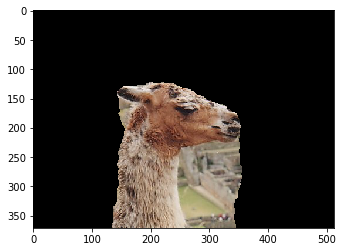

In [65]:
print ("Num_components = 7")
plt.imshow(out4)

## 5. Varying number of neighbours
- We test with 4 neighbours and 8 neighbours and compare the difference.
- In this case, we did not observe much difference.
- Ideally, we are supposed to observe that the foreground segmentaion is much more uniform across the diagonals as we increase the number of neighbours. A different set of images would show the same


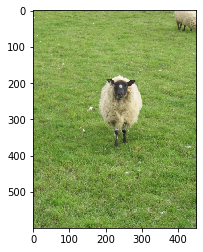

In [110]:
name = 'sheep'
img = image_list(name)
out1 = grabcut(image_list(name), bbox_list(name),2)
out2 = grabcut(image_list(name), bbox_list(name),2, num_neighbour = 4)
plt.imshow(img)

Number of neighbours = 8


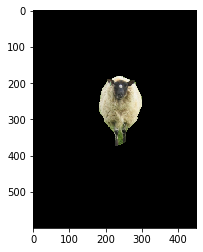

In [112]:
print ('Number of neighbours = 8')
plt.imshow(out1)

Number of neighbours = 4


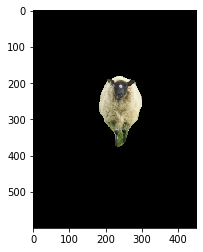

In [113]:
print ('Number of neighbours = 4')
plt.imshow(out2)

##  6. Variation of gamma
- Gamma is the gets multiplied with a certain value to be initialized to be source and sink depending on the case.
- Hence, when we increase gamma, there is a more stress for the neighbourhood nodes to have the same class.
- In this case, we get a better foreground segmentation.

Original image


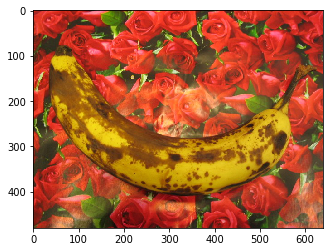

In [115]:
name = 'banana3'
img = image_list(name)
out1 = grabcut(image_list(name), bbox_list(name), gamma = 30)
out2 = grabcut(image_list(name),vg bbox_list(name), gamma = 40)
out3 = grabcut(image_list(name), bbox_list(name), gamma = 50)
out4 = grabcut(image_list(name), bbox_list(name), gamma = 60)
out5 = grabcut(image_list(name), bbox_list(name), gamma = 70)
print ("Original image")
plt.imshow(img)

Gamma = 30


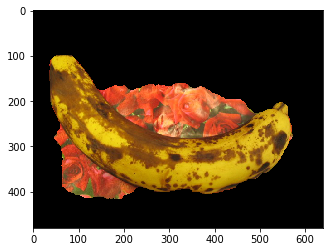

In [116]:
print ("Gamma = 30")
plt.imshow(out1)

Gamma = 40


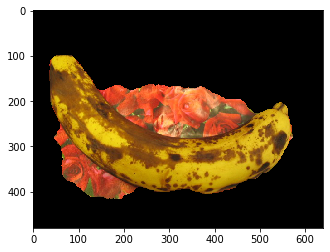

In [117]:
print ("Gamma = 40")
plt.imshow(out2)

Gamma = 50


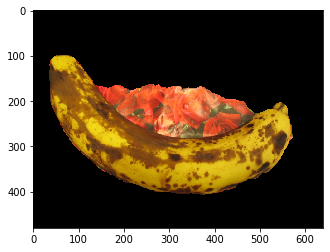

In [118]:
print ("Gamma = 50")
plt.imshow(out3)

Gamma = 60


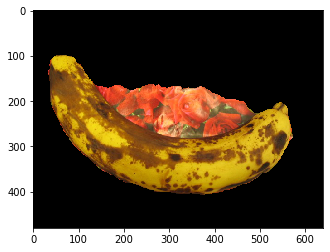

In [119]:
print ("Gamma = 60")
plt.imshow(out4)

Gamma = 70


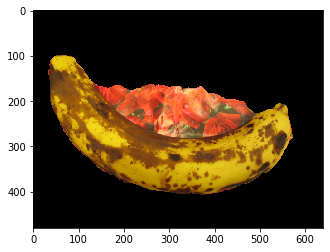

In [120]:
print ("Gamma = 70")
plt.imshow(out5)

## 7. Varying color space 
- In this particular case (banana3.jpg), better results seen for YCrCb than the rest
- In another case tested, person2.jpg, there is not much difference in the foreground segmentation.

Original Image


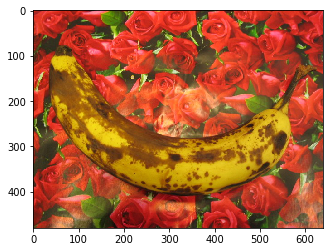

In [135]:
name = 'banana3'
print ("Original Image")
img = image_list(name)
plt.imshow(img)
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
out1 = grabcut(img, bbox_list(name),1)
out2 = grabcut(img_YCrCb, bbox_list(name),1)
out3 = grabcut(img_LAB, bbox_list(name),1)
out4 = grabcut(img_HSV, bbox_list(name),1)

RGB Color space


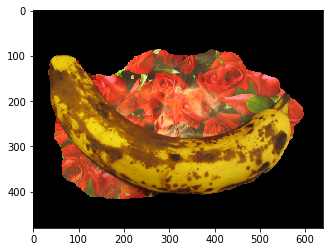

In [136]:
print ("RGB Color space")
plt.imshow(out1)

YCrCb colorspace


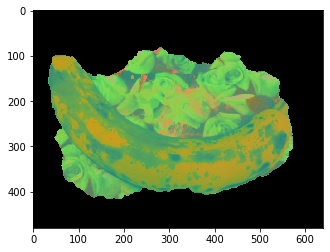

In [137]:
print ("YCrCb colorspace")
plt.imshow(out2)

LAB colorspace


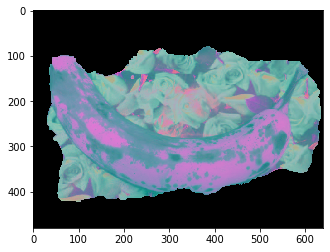

In [138]:
print ("LAB colorspace")
plt.imshow(out3)

HSV colorspace


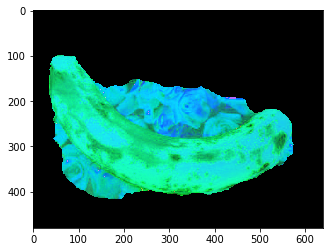

In [139]:
print ("HSV colorspace")
plt.imshow(out4)

Original Image


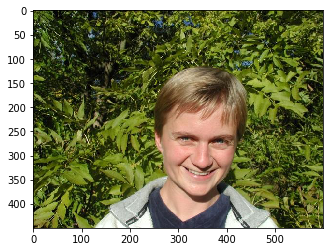

In [140]:
name = 'person2'
print ("Original Image")
img = image_list(name)
plt.imshow(img)
img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
out1 = grabcut(img, bbox_list(name),1)
out2 = grabcut(img_YCrCb, bbox_list(name),1)
out3 = grabcut(img_LAB, bbox_list(name),1)
out4 = grabcut(img_HSV, bbox_list(name),1)

RGB Color space


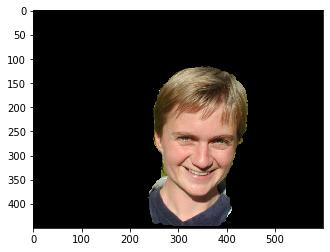

In [141]:
print ("RGB Color space")
plt.imshow(out1)

YCrCb colorspace


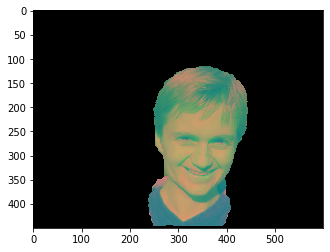

In [142]:
print ("YCrCb colorspace")
plt.imshow(out2)

LAB colorspace


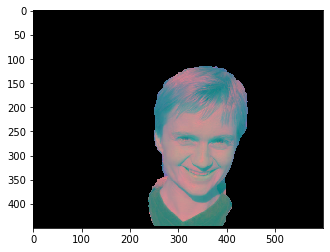

In [143]:
print ("LAB colorspace")
plt.imshow(out3)

HSV colorspace


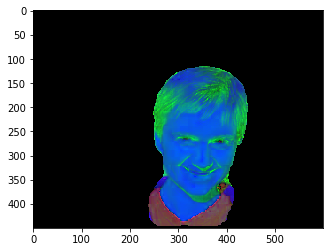

In [144]:
print ("HSV colorspace")
plt.imshow(out4)

## 8. Varying bounding box
- Variation of tightly versus loosly bounded
- We increase the size of the bounding box rectangle on the existing and test
- We see that the tightly bounded bounding box works better 
- This is due to the fact that a loose bounding box has more pixels, which gives more number of pixels to consider in the probable foreground, even though they are not in the foreground.

Original


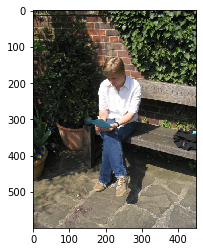

In [171]:
name = 'person6'
img = image_list(name)
out = grabcut(image_list(name), bbox_list(name),3)
print ("Original")
plt.imshow(img)
out1 = grabcut(img, (110, 105, 320,545),3)

Tight bounding box


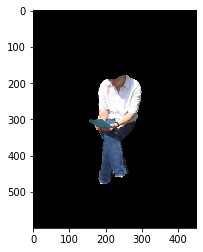

In [172]:
print ("Tight bounding box")
plt.imshow(out)

Loose bounding box


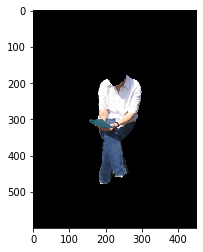

In [173]:
print ("Loose bounding box")
plt.imshow(out1)